In [54]:
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil import relativedelta
from ChildProject.projects import ChildProject
from ChildProject.annotations import AnnotationManager
import ast

DATA_PATH = Path('/home/engaclew/neurogen')

# Read measures
aclew_measures = pd.read_csv(DATA_PATH / 'aclew_measures_chunks.csv').fillna(0)
lena_measures = pd.read_csv(DATA_PATH / 'lena_measures_chunks.csv').fillna(0)
human_measures = pd.read_csv(DATA_PATH / 'human_measures_chunks.csv').fillna(0)

# Compute age and retrieve group_id information
children = pd.read_csv(DATA_PATH / 'data/L3_HIPAA_LENA_cleaned/metadata/children.csv')
recordings = pd.read_csv(DATA_PATH / 'data/L3_HIPAA_LENA_cleaned/metadata/recordings.csv')
recordings_data = recordings.merge(children, on='child_id')[['group_id', 'date_iso', 'recording_filename', 'child_sex', 'child_dob']]
def diff_month(row):
    d1 = datetime.strptime(row['date_iso'], '%Y-%m-%d')
    d2 = datetime.strptime(row['child_dob'], '%Y-%m-%d')
    return (d1.year - d2.year) * 12 + d1.month - d2.month
recordings_data['age'] = recordings_data.apply(lambda row: diff_month(row), axis=1)

aclew_measures = aclew_measures.merge(recordings_data, how='left', on='recording_filename')
lena_measures = lena_measures.merge(recordings_data, how='left', on='recording_filename')
human_measures = human_measures.merge(recordings_data, how='left', on='recording_filename')

# Merge pitch from speech-like and non-speech-like vocalizatiojns
def clean_pitch_concatenation(df):
    def safe_eval(x):
        if pd.isna(x):
            return []
        try:
            return ast.literal_eval(x)
        except (ValueError, SyntaxError):
            return []
    df['speechlike_pitch'] = df['speechlike_pitch'].apply(safe_eval)
    df['nonspeechlike_pitch'] = df['nonspeechlike_pitch'].apply(safe_eval)
    df['pitch'] = df.apply( lambda row: row['speechlike_pitch'] + row['nonspeechlike_pitch'],  axis=1)
    return df
    
aclew_measures = clean_pitch_concatenation(aclew_measures)
lena_measures = clean_pitch_concatenation(lena_measures)
human_measures = clean_pitch_concatenation(human_measures)

# Compute CVC
def compute_CVC(data):
    if 'can_voc_CHI' in data.columns and 'non_can_voc_CHI' in data.columns:
        data['CVC'] = data['can_voc_CHI'] + data['non_can_voc_CHI']
    return data

aclew_measures = compute_CVC(aclew_measures)
human_measures = compute_CVC(human_measures)


# Group per child
def group_clips(df):
    
    # Define aggregation rules for each column
    agg_rules = {
        'group_id': 'first',
        'child_id': 'first',
        'voc_chi': ['sum', lambda x: x.quantile(0.5), lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
        'voc_dur_chi': ['sum', lambda x: x.quantile(0.5), lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
        'CVC': ['sum', lambda x: x.quantile(0.5), lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
        'wc_adu': ['sum', lambda x: x.quantile(0.5), lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
        '5s_CTC': ['sum', lambda x: x.quantile(0.5), lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
        'pitch': 'sum'
    }
    
    # Group by recording_filename and apply aggregations
    grouped = df.groupby('recording_filename').agg(agg_rules).reset_index()
    grouped.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in grouped.columns]    
    rename_dict = {}
    variables = ['voc_chi', 'voc_dur_chi', 'CVC', 'wc_adu', '5s_CTC']
    for var in variables:
        rename_dict[f'{var}_<lambda_0>'] = f'{var}_q2'
        rename_dict[f'{var}_<lambda_1>'] = f'{var}_q1'
        rename_dict[f'{var}_<lambda_2>'] = f'{var}_q3'
    rename_dict['pitch_sum'] = 'pitch'
    rename_dict['group_id_first'] = 'group_id'
    rename_dict['child_id_first'] = 'child_id'
    grouped = grouped.rename(columns=rename_dict)
    return grouped

aclew_measures = group_clips(aclew_measures)
lena_measures = group_clips(lena_measures)
human_measures = group_clips(human_measures)
def compute_pitch_statistics(df):
    # Define a safe function to calculate statistics that handles empty arrays
    def safe_median(x):
        return np.nan if len(x) == 0 else np.median(x)
    
    def safe_percentile(x, q):
        return np.nan if len(x) == 0 else np.percentile(x, q)
    
    # Apply the safe functions to get initial values with NaNs for empty arrays
    df['median_pitch'] = df['pitch'].map(safe_median)
    df['first_quart_pitch'] = df['pitch'].map(lambda x: safe_percentile(x, 25))
    df['third_quart_pitch'] = df['pitch'].map(lambda x: safe_percentile(x, 75))
    
    # For each diagnostic group, calculate the mean of each pitch statistic
    group_means = df.groupby('group_id')[['median_pitch', 'first_quart_pitch', 'third_quart_pitch']].transform('mean')
    
    # Replace NaN values with their respective group means
    df['median_pitch'] = df['median_pitch'].fillna(group_means['median_pitch'])
    df['first_quart_pitch'] = df['first_quart_pitch'].fillna(group_means['first_quart_pitch'])
    df['third_quart_pitch'] = df['third_quart_pitch'].fillna(group_means['third_quart_pitch'])
    
    # In case any groups have all NaNs for a measure, fall back to the overall mean
    if df['median_pitch'].isna().any():
        overall_mean_median = df['median_pitch'].mean(skipna=True)
        df['median_pitch'] = df['median_pitch'].fillna(overall_mean_median)
        
    if df['first_quart_pitch'].isna().any():
        overall_mean_first_quart = df['first_quart_pitch'].mean(skipna=True)
        df['first_quart_pitch'] = df['first_quart_pitch'].fillna(overall_mean_first_quart)
        
    if df['third_quart_pitch'].isna().any():
        overall_mean_third_quart = df['third_quart_pitch'].mean(skipna=True)
        df['third_quart_pitch'] = df['third_quart_pitch'].fillna(overall_mean_third_quart)
    
    return df
columns = ['group_id', 'child_id', 
           'voc_chi_sum', 'voc_chi_q1', 'voc_chi_q2', 'voc_chi_q3', 
           'voc_dur_chi_sum', 'voc_dur_chi_q1', 'voc_dur_chi_q2', 'voc_dur_chi_q3',
           'CVC_sum', 'CVC_q1', 'CVC_q2', 'CVC_q3', 
           'wc_adu_sum', 'wc_adu_q1', 'wc_adu_q2', 'wc_adu_q3', 
           '5s_CTC_sum', '5s_CTC_q1', '5s_CTC_q2', '5s_CTC_q3',
           'median_pitch', 'first_quart_pitch', 'third_quart_pitch']
aclew_measures = compute_pitch_statistics(aclew_measures)[columns]
lena_measures = compute_pitch_statistics(lena_measures)[columns]
human_measures = compute_pitch_statistics(human_measures)[columns]

ACLEW - Best SVM parameters: {'classifier__C': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
ACLEW acc = 0.26 (13.0 correctly diagnosed)
LENA - Best SVM parameters: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
LENA acc = 0.28 (14.0 correctly diagnosed)
human - Best SVM parameters: {'classifier__C': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
human acc = 0.22 (11.0 correctly diagnosed)


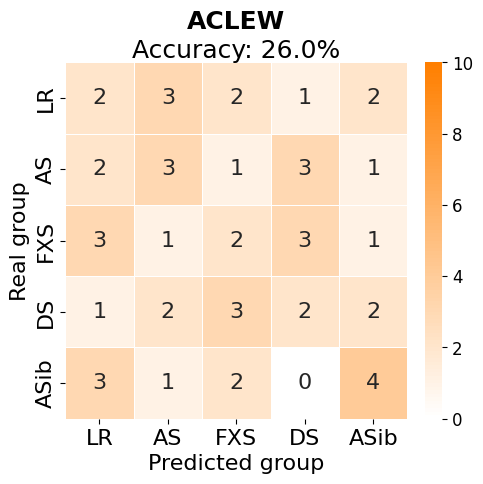

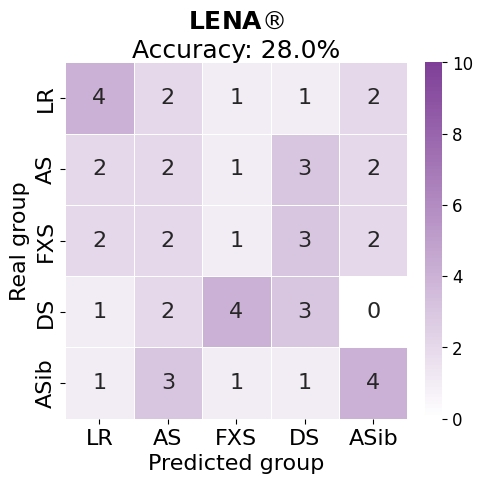

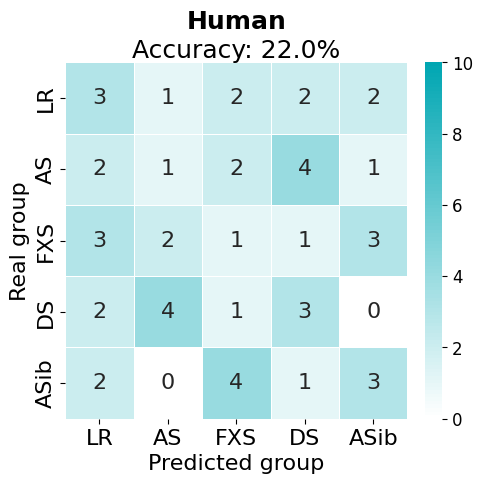


=== Summary of Results with Tuned SVM ===
ACLEW: acc = 0.26 (13.0 correctly diagnosed)
Best parameters: {'classifier__C': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
LENA: acc = 0.28 (14.0 correctly diagnosed)
Best parameters: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
human: acc = 0.22 (11.0 correctly diagnosed)
Best parameters: {'classifier__C': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}

Chance-level acc = 0.2 (10.0 correctly diagnosed)


In [56]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneOut, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sn
import matplotlib
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 16, 'legend.handleheight':1, 'hatch.linewidth': 1.0,
                           'lines.markersize':4, 'lines.linewidth':1, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
# Dictionary to store all results
results = {
    'ACLEW': {},
    'LENA': {},
    'human': {}
}

def evaluate_measures_with_tuned_svm(X, y, name, feature_names, group_classes=None, random_state=42):
    """
    Evaluates the dataset with a tuned SVM model
    
    Parameters:
        X: feature matrix
        y: target labels
        name: source of data ('ACLEW', 'LENA', or 'human')
        feature_names: names of the features
        group_classes: if 'three_groups', combine some labels
    """
    if group_classes == 'three_groups':
        # Create a copy to avoid modifying original labels
        y = y.copy()
        # Combine angelman, down, fragile_x into 'other'
        other_conditions = ['angelman_syndrome', 'down_syndrome', 'fragile_x_syndrome']
        y[np.isin(y, other_conditions)] = 'other'
    
    # First, let's use feature selection with Random Forest
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(
            C=0.1,  # Stronger regularization
            penalty='l2',
            solver='liblinear',
            class_weight='balanced',
            max_iter=1000
        ))
    ])
    
    # Define parameter grid for SVM
    param_grid = {
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__penalty': ['l2'],
        'classifier__solver': ['liblinear']
    }
    
    # Use stratified k-fold for hyperparameter tuning
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    
    grid_search = GridSearchCV(
        pipeline, 
        param_grid=param_grid,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1
    )
    
    # Fit grid search to find optimal parameters
    grid_search.fit(X, y)
    
    # Get best parameters
    best_params = grid_search.best_params_
    print(f"{name} - Best SVM parameters: {best_params}")
    
    # Create a new pipeline with best parameters
    best_pipeline = clone(pipeline)
    for param, value in best_params.items():
        component, param_name = param.split('__')
        setattr(best_pipeline.named_steps[component], param_name, value)
    
    # Evaluate with leave-one-out cross-validation
    loo = LeaveOneOut()
    
    predictions = []
    true_labels = []
    probabilities = []
    
    for train_idx, test_idx in loo.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Fit the pipeline with best parameters
        best_pipeline.fit(X_train, y_train)
        
        # Make predictions
        pred = best_pipeline.predict(X_test)
        proba = best_pipeline.predict_proba(X_test)
        
        # Store results
        predictions.append(pred[0])
        true_labels.append(y_test[0])
        probabilities.append(proba[0])
    
    # Calculate accuracy and confusion matrix
    accuracy = accuracy_score(true_labels, predictions)
    conf_matrix = confusion_matrix(true_labels, predictions, labels=np.unique(y))
    
    # Store results
    results[name] = {
        'accuracy': accuracy,
        'predictions': predictions,
        'true_labels': true_labels,
        'probabilities': probabilities,
        'confusion_matrix': conf_matrix,
        'unique_labels': np.unique(y),
        'best_params': best_params
    }
    
    # Print accuracy
    num_correct = sum(p == t for p, t in zip(predictions, true_labels))
    print(f"{name} acc = {accuracy:.2f} ({num_correct:.1f} correctly diagnosed)")
    
    return results[name]

# Plot confusion matrices

def plot_confusion_matrix(results, method_name, color, title=None):
    """Plot confusion matrix for a specific method"""
    conf = results[method_name]['confusion_matrix']
    unique_labels = list(results[method_name]['unique_labels'])
    
    # Define orders and labels based on number of classes
    if len(unique_labels) == 5:  # five groups case
        order = ['low_risk', 'angelman_syndrome', 'fragile_x_syndrome', 'down_syndrome', 'autism_sibling']
        labels = ['LR', 'AS', 'FXS', 'DS', 'ASib']
    elif len(unique_labels) == 3:  # three groups case
        order = ['low_risk', 'autism_sibling', 'other']
        labels = ['LR', 'ASib', 'Neurogen']
    elif len(unique_labels) == 2:  # two groups case
        order = ['low_risk', 'other']
        labels = ['LR', 'AT']
    
    # Reorder the confusion matrix
    idx = [unique_labels.index(o) for o in order]
    conf = conf[idx][:, idx]
    
    # Calculate accuracy
    accuracy = np.sum(np.diag(conf)) / np.sum(conf) * 100
    
    # Create custom colormap
    colors = ['white', color]
    n_bins = 100
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("custom", colors, N=n_bins)
    
    cm = 1/2.54
    fig, ax = plt.subplots(1,1, figsize=(12*cm,12*cm), constrained_layout=True)
    
    sn.heatmap(conf, annot=True, ax=ax, fmt="d", linewidth=.5, 
               vmin=0, vmax=10, cmap=cmap)
    
    # Set title with accuracy
    if title is None:
        # Just accuracy, not in bold
        ax.set_title(f'Accuracy: {accuracy:.1f}%', fontsize=18)
    else:
        # Title in bold, accuracy not in bold
        title_obj = ax.set_title(f'{title}\nAccuracy: {accuracy:.1f}%', fontsize=18)
        
        # Split the title text to make only the first line bold
        title_text = title_obj.get_text().split('\n')
        if len(title_text) > 1:
            ax.set_title('')  # Clear the current title
            
            # Add the bold title
            ax.text(0.5, 1.08, title_text[0], transform=ax.transAxes, 
                   ha='center', va='bottom', fontsize=18, fontweight='bold')
            
            # Add the non-bold accuracy line
            ax.text(0.5, 1.00, title_text[1], transform=ax.transAxes, 
                   ha='center', va='bottom', fontsize=18)
        
    ax.set_yticklabels(labels, fontsize=16)
    ax.set_xticklabels(labels, fontsize=16)
    ax.set_ylabel('Real group', fontsize=16)
    ax.set_xlabel('Predicted group', fontsize=16)
    
    return fig

# Plot for each method with correct colors
colors = {
    'ACLEW': '#FF7F00',  # orange
    'LENA': '#7F3F98',   # purple
    'human': '#00A6B2'   # teal
}

titles = {
    'ACLEW': 'ACLEW',
    'LENA': r'LENA$\circledR$',
    'human': 'Human'
}

# Run analysis for each measurement source
for df, name in [(aclew_measures, 'ACLEW'), 
                 (lena_measures, 'LENA'), 
                 (human_measures, 'human')]:
    features = df.drop(['group_id', 'child_id'], axis=1)
    feature_names = features.columns
    X = features.values
    labels = df['group_id'].values
    
    results[name] = evaluate_measures_with_tuned_svm(X, labels, name, feature_names, group_classes=None)

for method, color in colors.items():
    fig = plot_confusion_matrix(results, method, color, title=titles[method])
    plt.savefig(f'/home/engaclew/neurogen/figures/diagnostic_classifiers/{method}_tuned_svm_classifier_30_min.png', dpi=300)
    plt.show()

# Print summary of results
print("\n=== Summary of Results with Tuned SVM ===")
for method in results:
    acc = results[method]['accuracy']
    num_correct = sum(p == t for p, t in zip(
        results[method]['predictions'], 
        results[method]['true_labels']
    ))
    best_params = results[method]['best_params']
    print(f"{method}: acc = {acc:.2f} ({num_correct:.1f} correctly diagnosed)")
    print(f"Best parameters: {best_params}")

print("\nChance-level acc = 0.2 (10.0 correctly diagnosed)")

In [43]:
for random_state in range(35,45):
    print(random_state)
    for df, name in [(aclew_measures, 'ACLEW'), 
                     (lena_measures, 'LENA'), 
                     (human_measures, 'human')]:
        features = df.drop(['group_id', 'child_id'], axis=1)
        feature_names = features.columns
        X = features.values
        labels = df['group_id'].values
        
        results[name] = evaluate_measures_with_tuned_svm(X, labels, name, feature_names, group_classes=None, random_state=random_state)
        conf = results[name]['confusion_matrix']
        unique_labels = list(results[name]['unique_labels'])
        
        order = ['low_risk', 'angelman_syndrome', 'fragile_x_syndrome', 'down_syndrome', 'autism_sibling']
        labels = ['LR', 'AS', 'FXS', 'DS', 'ASib']
        
        # Reorder the confusion matrix
        idx = [unique_labels.index(o) for o in order]
        conf = conf[idx][:, idx]
        # Calculate accuracy
        accuracy = np.sum(np.diag(conf)) / np.sum(conf) * 100
        print(name, accuracy)
    print('____')

35
ACLEW - Best SVM parameters: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
ACLEW acc = 0.20 (10.0 correctly diagnosed)
ACLEW 20.0
LENA - Best SVM parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
LENA acc = 0.22 (11.0 correctly diagnosed)
LENA 22.0
human - Best SVM parameters: {'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
human acc = 0.20 (10.0 correctly diagnosed)
human 20.0
____
36
ACLEW - Best SVM parameters: {'classifier__C': 0.001, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
ACLEW acc = 0.30 (15.0 correctly diagnosed)
ACLEW 30.0
LENA - Best SVM parameters: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
LENA acc = 0.28 (14.0 correctly diagnosed)
LENA 28.000000000000004
human - Best SVM parameters: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
human acc = 0.1

In [51]:
# Now let's add canonical vs. non-canonical
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil import relativedelta
from ChildProject.projects import ChildProject
from ChildProject.annotations import AnnotationManager
import ast

DATA_PATH = Path('/home/engaclew/neurogen')

# Read measures
aclew_measures = pd.read_csv(DATA_PATH / 'aclew_measures_chunks.csv').fillna(0)
human_measures = pd.read_csv(DATA_PATH / 'human_measures_chunks.csv').fillna(0)

# Compute age and retrieve group_id information
children = pd.read_csv(DATA_PATH / 'data/L3_HIPAA_LENA_cleaned/metadata/children.csv')
recordings = pd.read_csv(DATA_PATH / 'data/L3_HIPAA_LENA_cleaned/metadata/recordings.csv')
recordings_data = recordings.merge(children, on='child_id')[['group_id', 'date_iso', 'recording_filename', 'child_sex', 'child_dob']]
def diff_month(row):
    d1 = datetime.strptime(row['date_iso'], '%Y-%m-%d')
    d2 = datetime.strptime(row['child_dob'], '%Y-%m-%d')
    return (d1.year - d2.year) * 12 + d1.month - d2.month
recordings_data['age'] = recordings_data.apply(lambda row: diff_month(row), axis=1)

aclew_measures = aclew_measures.merge(recordings_data, how='left', on='recording_filename')
human_measures = human_measures.merge(recordings_data, how='left', on='recording_filename')

# Merge pitch from speech-like and non-speech-like vocalizatiojns
def clean_pitch_concatenation(df):
    def safe_eval(x):
        if pd.isna(x):
            return []
        try:
            return ast.literal_eval(x)
        except (ValueError, SyntaxError):
            return []
    df['speechlike_pitch'] = df['speechlike_pitch'].apply(safe_eval)
    df['nonspeechlike_pitch'] = df['nonspeechlike_pitch'].apply(safe_eval)
    df['pitch'] = df.apply( lambda row: row['speechlike_pitch'] + row['nonspeechlike_pitch'],  axis=1)
    return df
    
aclew_measures = clean_pitch_concatenation(aclew_measures)
human_measures = clean_pitch_concatenation(human_measures)
print(human_measures.columns)
# Compute CVC
def compute_CVC(data):
    if 'can_voc_CHI' in data.columns and 'non_can_voc_CHI' in data.columns:
        data['CVC'] = data['can_voc_CHI'] + data['non_can_voc_CHI']
    return data

aclew_measures = compute_CVC(aclew_measures)
human_measures = compute_CVC(human_measures)


# Group per child
def group_clips(df):
    
    # Define aggregation rules for each column
    agg_rules = {
        'group_id': 'first',
        'child_id': 'first',
        'voc_chi': ['sum', lambda x: x.quantile(0.5), lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
        'voc_dur_chi': ['sum', lambda x: x.quantile(0.5), lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
        'CVC': ['sum', lambda x: x.quantile(0.5), lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
        'wc_adu': ['sum', lambda x: x.quantile(0.5), lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
        '5s_CTC': ['sum', lambda x: x.quantile(0.5), lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
        'can_voc_CHI': ['sum', lambda x: x.quantile(0.5), lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
        'can_voc_dur_CHI': ['sum', lambda x: x.quantile(0.5), lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)],
        'pitch': 'sum'
    }
    
    # Group by recording_filename and apply aggregations
    grouped = df.groupby('recording_filename').agg(agg_rules).reset_index()
    grouped.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in grouped.columns]    
    rename_dict = {}
    variables = ['voc_chi', 'voc_dur_chi', 'can_voc_dur_CHI', 'can_voc_CHI', 'CVC', 'wc_adu', '5s_CTC']
    for var in variables:
        rename_dict[f'{var}_<lambda_0>'] = f'{var}_q2'
        rename_dict[f'{var}_<lambda_1>'] = f'{var}_q1'
        rename_dict[f'{var}_<lambda_2>'] = f'{var}_q3'
    rename_dict['pitch_sum'] = 'pitch'
    rename_dict['group_id_first'] = 'group_id'
    rename_dict['child_id_first'] = 'child_id'
    grouped = grouped.rename(columns=rename_dict)
    return grouped
    
aclew_measures = group_clips(aclew_measures)
human_measures = group_clips(human_measures)
def compute_pitch_statistics(df):
    # Define a safe function to calculate statistics that handles empty arrays
    def safe_median(x):
        return np.nan if len(x) == 0 else np.median(x)
    
    def safe_percentile(x, q):
        return np.nan if len(x) == 0 else np.percentile(x, q)
    
    # Apply the safe functions to get initial values with NaNs for empty arrays
    df['median_pitch'] = df['pitch'].map(safe_median)
    df['first_quart_pitch'] = df['pitch'].map(lambda x: safe_percentile(x, 25))
    df['third_quart_pitch'] = df['pitch'].map(lambda x: safe_percentile(x, 75))
    
    # For each diagnostic group, calculate the mean of each pitch statistic
    group_means = df.groupby('group_id')[['median_pitch', 'first_quart_pitch', 'third_quart_pitch']].transform('mean')
    
    # Replace NaN values with their respective group means
    df['median_pitch'] = df['median_pitch'].fillna(group_means['median_pitch'])
    df['first_quart_pitch'] = df['first_quart_pitch'].fillna(group_means['first_quart_pitch'])
    df['third_quart_pitch'] = df['third_quart_pitch'].fillna(group_means['third_quart_pitch'])
    
    # In case any groups have all NaNs for a measure, fall back to the overall mean
    if df['median_pitch'].isna().any():
        overall_mean_median = df['median_pitch'].mean(skipna=True)
        df['median_pitch'] = df['median_pitch'].fillna(overall_mean_median)
        
    if df['first_quart_pitch'].isna().any():
        overall_mean_first_quart = df['first_quart_pitch'].mean(skipna=True)
        df['first_quart_pitch'] = df['first_quart_pitch'].fillna(overall_mean_first_quart)
        
    if df['third_quart_pitch'].isna().any():
        overall_mean_third_quart = df['third_quart_pitch'].mean(skipna=True)
        df['third_quart_pitch'] = df['third_quart_pitch'].fillna(overall_mean_third_quart)
    
    return df
columns = ['group_id', 'child_id', 
           'voc_chi_sum', 'voc_chi_q1', 'voc_chi_q2', 'voc_chi_q3', 
           'voc_dur_chi_sum', 'voc_dur_chi_q1', 'voc_dur_chi_q2', 'voc_dur_chi_q3',
           'CVC_sum', 'CVC_q1', 'CVC_q2', 'CVC_q3', 
           'wc_adu_sum', 'wc_adu_q1', 'wc_adu_q2', 'wc_adu_q3', 
           '5s_CTC_sum', '5s_CTC_q1', '5s_CTC_q2', '5s_CTC_q3',
           'can_voc_CHI_sum', 'can_voc_CHI_q1', 'can_voc_CHI_q3', 'can_voc_CHI_q3',
           'can_voc_dur_CHI_sum', 'can_voc_dur_CHI_q1', 'can_voc_dur_CHI_q3', 'can_voc_dur_CHI_q3',
           'median_pitch', 'first_quart_pitch', 'third_quart_pitch']
aclew_measures = compute_pitch_statistics(aclew_measures)[columns]
human_measures = compute_pitch_statistics(human_measures)[columns]

Index(['recording_filename', 'segment_onset', 'segment_offset', 'child_id',
       'duration_eaf/an1', 'voc_dur_chi', 'non_can_voc_dur_CHI',
       'cry_voc_dur_CHI', 'cp_dur', 'can_voc_CHI', 'non_can_voc_CHI', '5s_CTC',
       'can_voc_dur_CHI', 'wc_adu', 'wc_fem', 'avg_voc_dur_chi', 'voc_chi',
       'voc_dur_och', 'voc_dur_fem', 'voc_dur_mal', 'wc_mal', 'overlap_dur',
       'speechlike_pitch', 'nonspeechlike_pitch', 'group_id', 'date_iso',
       'child_sex', 'child_dob', 'age', 'pitch'],
      dtype='object')


(50, 31)
ACLEW - Best SVM parameters: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
ACLEW acc = 0.26 (13.0 correctly diagnosed)
(50, 31)
human - Best SVM parameters: {'classifier__C': 0.001, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
human acc = 0.36 (18.0 correctly diagnosed)


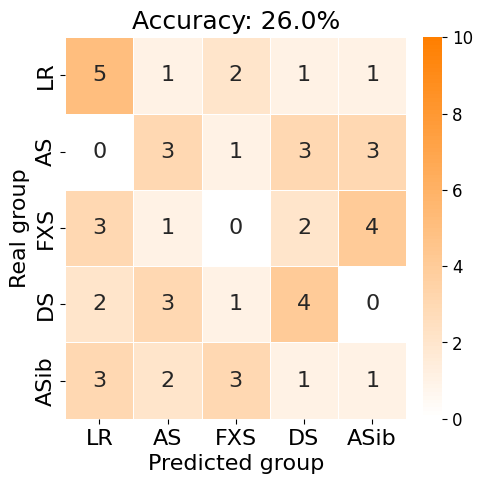

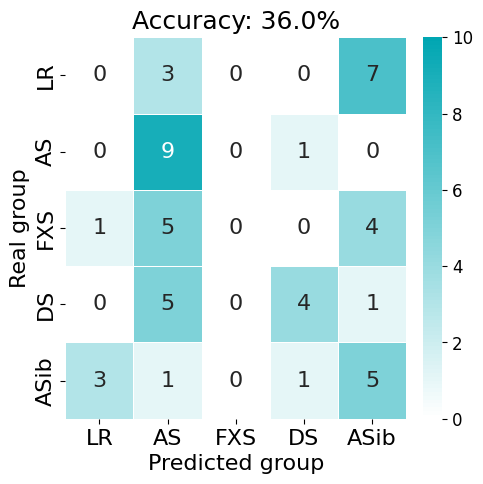


=== Summary of Results with Tuned SVM ===
ACLEW: acc = 0.26 (13.0 correctly diagnosed)
Best parameters: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
human: acc = 0.36 (18.0 correctly diagnosed)
Best parameters: {'classifier__C': 0.001, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}

Chance-level acc = 0.2 (10.0 correctly diagnosed)


In [53]:
colors = {
    'ACLEW': '#FF7F00',  # orange
    'human': '#00A6B2'   # teal
}

# Run analysis for each measurement source
results = {}
for df, name in [(aclew_measures, 'ACLEW'), 
                 (human_measures, 'human')]:
    features = df.drop(['group_id', 'child_id'], axis=1)
    feature_names = features.columns
    X = features.values
    print(X.shape)
    labels = df['group_id'].values
    
    results[name] = evaluate_measures_with_tuned_svm(X, labels, name, feature_names, group_classes=None, random_state=42)

for method, color in colors.items():
    fig = plot_confusion_matrix(results, method, color)
    plt.savefig(f'/home/engaclew/neurogen/figures/diagnostic_classifiers/{method}_tuned_svm_classifier_30_min_with_canonical.png', dpi=300)
    plt.show()

# Print summary of results
print("\n=== Summary of Results with Tuned SVM ===")
for method in results:
    acc = results[method]['accuracy']
    num_correct = sum(p == t for p, t in zip(
        results[method]['predictions'], 
        results[method]['true_labels']
    ))
    best_params = results[method]['best_params']
    print(f"{method}: acc = {acc:.2f} ({num_correct:.1f} correctly diagnosed)")
    print(f"Best parameters: {best_params}")

print("\nChance-level acc = 0.2 (10.0 correctly diagnosed)")

In [48]:
for random_state in range(20,43):
    print(random_state)
    for df, name in [(aclew_measures, 'ACLEW'), 
                     (human_measures, 'human')]:
        features = df.drop(['group_id', 'child_id'], axis=1)
        feature_names = features.columns
        X = features.values
        labels = df['group_id'].values
        
        results[name] = evaluate_measures_with_tuned_svm(X, labels, name, feature_names, group_classes=None, random_state=random_state)
        conf = results[name]['confusion_matrix']
        unique_labels = list(results[name]['unique_labels'])
        
        order = ['low_risk', 'angelman_syndrome', 'fragile_x_syndrome', 'down_syndrome', 'autism_sibling']
        labels = ['LR', 'AS', 'FXS', 'DS', 'ASib']
        
        # Reorder the confusion matrix
        idx = [unique_labels.index(o) for o in order]
        conf = conf[idx][:, idx]
        # Calculate accuracy
        accuracy = np.sum(np.diag(conf)) / np.sum(conf) * 100
        print(name, accuracy)
    print('____')

20
ACLEW - Best SVM parameters: {'classifier__C': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
ACLEW acc = 0.22 (11.0 correctly diagnosed)
ACLEW 22.0
human - Best SVM parameters: {'classifier__C': 0.001, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
human acc = 0.36 (18.0 correctly diagnosed)
human 36.0
____
21
ACLEW - Best SVM parameters: {'classifier__C': 0.001, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
ACLEW acc = 0.26 (13.0 correctly diagnosed)
ACLEW 26.0
human - Best SVM parameters: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
human acc = 0.24 (12.0 correctly diagnosed)
human 24.0
____
22
ACLEW - Best SVM parameters: {'classifier__C': 0.001, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
ACLEW acc = 0.26 (13.0 correctly diagnosed)
ACLEW 26.0
human - Best SVM parameters: {'classifier__C': 0.001, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
huma

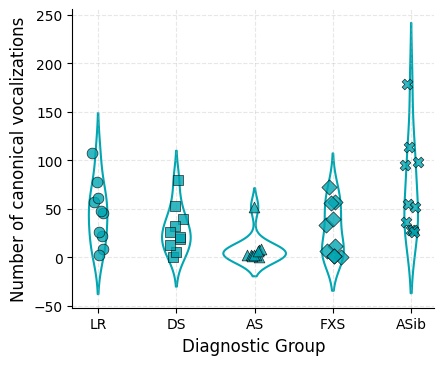

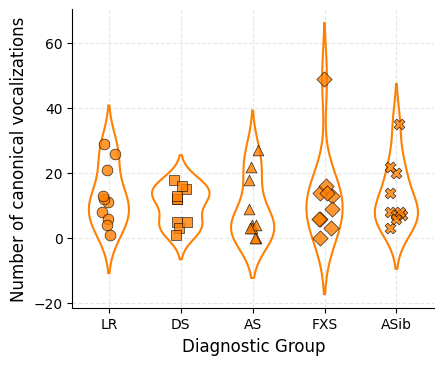

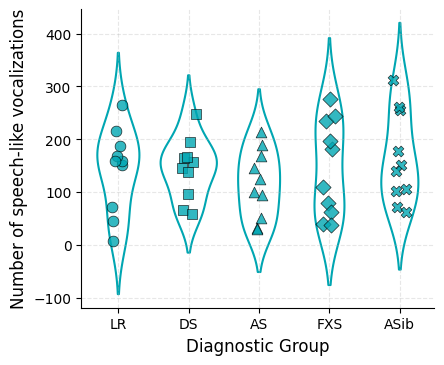

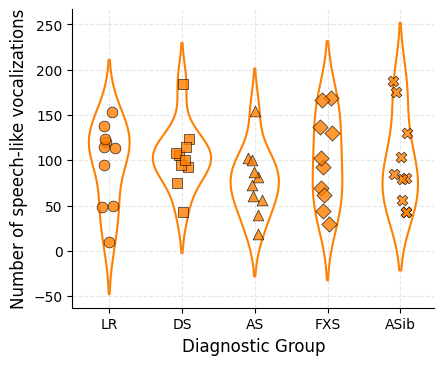

In [240]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib as mpl

def plot_measure(data, column_name, color='#00A6B2', save_path=None):
    """
    Creates a violin plot with scatter points showing canonical vocalizations across diagnostic groups.
    
    Parameters:
        data (DataFrame): DataFrame containing the data to plot
        column_name (str): Name of the column containing canonical vocalization data
        color (str): Color to use for the plot elements (default: seal/teal color)
        save_path (str, optional): Path to save the figure, if None the figure won't be saved
        
    Returns:
        fig, ax: The figure and axis objects
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    from scipy import stats
    import pandas as pd
    
    # Define constants
    cm = 1/2.54  # centimeters to inches conversion

    if column_name == 'can_voc_CHI_sum':
        ylabel = 'Number of canonical vocalizations'
    elif column_name == 'CVC_sum':
        ylabel = 'Number of speech-like vocalizations'
    else:
        raise ValueError('No ylabel for this column')
        
    # Define different markers for each group
    markers = {
        'LR': 'o',        # circle
        'DS': 's',        # square
        'AS': '^',        # triangle up
        'FXS': 'D',       # diamond
        'ASib': 'X'       # x (filled)
    }
    
    # Create a mapping from full group names to abbreviated names
    group_mapping = {
        'low_risk': 'LR',
        'down_syndrome': 'DS', 
        'angelman_syndrome': 'AS',
        'fragile_x_syndrome': 'FXS',
        'autism_sibling': 'ASib'
    }
    
    # Create a copy of the dataframe with mapped group names
    plot_data = data.copy()
    plot_data['group_label'] = plot_data['group_id'].map(group_mapping)
    
    # Create ordered groups
    group_order = ['LR', 'DS', 'AS', 'FXS', 'ASib']
    
    # Create a figure with improved styling
    fig, ax = plt.subplots(figsize=(12*cm, 10*cm))
    
    # Create violin plot with custom styling
    violin_parts = sns.violinplot(x='group_label', y=column_name, data=plot_data, 
                               order=group_order, ax=ax, inner=None, 
                               linewidth=1.5, color='white')
    
    # Customize violin colors - all in specified color
    for pc in violin_parts.collections:
        pc.set_facecolor('none')
        pc.set_edgecolor(color)
    
    # Calculate kernel density for point placement
    group_kdes = {}
    for group in group_order:
        group_data = plot_data[plot_data['group_label'] == group][column_name].values
        if len(group_data) > 1:  # Need at least 2 points for KDE
            group_kdes[group] = stats.gaussian_kde(group_data)
        else:
            group_kdes[group] = None
    
    # Function to calculate x position based on density
    def get_x_position(y_val, kde, center_x, max_width=0.3):
        if kde is None or len(kde.dataset) < 2:
            return center_x + np.random.uniform(-0.1, 0.1)
        density = kde(y_val)[0]
        max_density = kde(kde.dataset).max()
        width = max_width * (density / max_density)
        return center_x + np.random.uniform(-width, width)
    
    # Plot individual points with jitter based on density
    for i, group in enumerate(group_order):
        group_data = plot_data[plot_data['group_label'] == group][column_name].values
        kde = group_kdes[group]
        
        # Plot points with different markers for each group
        for y_val in group_data:
            x_pos = get_x_position(y_val, kde, i)
            ax.scatter(x_pos, y_val, color=color, edgecolor='black',
                      s=60, marker=markers[group], zorder=3, linewidth=0.5, alpha=0.8)
    
    # Add labels and styling
    ax.set_xlabel('Diagnostic Group', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.3, zorder=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set tick labels
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    plt.tight_layout()
    
    # Save the figure if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    

plot_measure(
    human_measures, 
    'can_voc_CHI_sum', 
    color='#00A6B2',  # teal/seal color
    save_path='/home/engaclew/neurogen/figures/diagnostic_classifiers/human_canonical_voc_count.png'
)

plot_measure(
    aclew_measures, 
    'can_voc_CHI_sum', 
    color='#FF7F00',  # teal/seal color
    save_path='/home/engaclew/neurogen/figures/diagnostic_classifiers/aclew_canonical_voc_count.png'
)

plot_measure(
    human_measures, 
    'CVC_sum', 
    color='#00A6B2',  # teal/seal color
    save_path='/home/engaclew/neurogen/figures/diagnostic_classifiers/human_CVC.png'
)

plot_measure(
    aclew_measures, 
    'CVC_sum', 
    color='#FF7F00',  # teal/seal color
    save_path='/home/engaclew/neurogen/figures/diagnostic_classifiers/aclew_CVC.png'
)

In [236]:
human_measures.columns

Index(['group_id', 'child_id', 'voc_chi_sum', 'voc_chi_q1', 'voc_chi_q2',
       'voc_chi_q3', 'voc_dur_chi_sum', 'voc_dur_chi_q1', 'voc_dur_chi_q2',
       'voc_dur_chi_q3', 'CVC_sum', 'CVC_q1', 'CVC_q2', 'CVC_q3', 'wc_adu_sum',
       'wc_adu_q1', 'wc_adu_q2', 'wc_adu_q3', '5s_CTC_sum', '5s_CTC_q1',
       '5s_CTC_q2', '5s_CTC_q3', 'can_voc_CHI_sum', 'can_voc_CHI_q1',
       'can_voc_CHI_q3', 'can_voc_CHI_q3', 'can_voc_dur_CHI_sum',
       'can_voc_dur_CHI_q1', 'can_voc_dur_CHI_q3', 'can_voc_dur_CHI_q3',
       'median_pitch', 'first_quart_pitch', 'third_quart_pitch'],
      dtype='object')

In [ ]:
ig, ax = plt.subplots(figsize=(12*cm, 10*cm))

# Create violin plot with custom styling
violin_parts = sns.violinplot(x='group_label', y='can_voc_CHI_sum', data=plot_data, 
                           order=group_order, ax=ax, inner=None, 
                           linewidth=1.5, color='white')

# Customize violin colors - all in seal color
for pc in violin_parts.collections:
    pc.set_facecolor('none')
    pc.set_edgecolor(seal_color)

# Calculate kernel density for point placement
group_kdes = {}
for group in group_order:
    group_data = plot_data[plot_data['group_label'] == group]['can_voc_CHI_sum'].values
    if len(group_data) > 1:  # Need at least 2 points for KDE
        group_kdes[group] = stats.gaussian_kde(group_data)
    else:
        group_kdes[group] = None

# Function to calculate x position based on density
def get_x_position(y_val, kde, center_x, max_width=0.3):
    if kde is None or len(kde.dataset) < 2:
        return center_x + np.random.uniform(-0.1, 0.1)
    density = kde(y_val)[0]
    max_density = kde(kde.dataset).max()
    width = max_width * (density / max_density)
    return center_x + np.random.uniform(-width, width)

# Plot individual points with jitter based on density
for i, group in enumerate(group_order):
    group_data = plot_data[plot_data['group_label'] == group]['can_voc_CHI_sum'].values
    kde = group_kdes[group]
    
    # Plot points with different markers for each group
    for y_val in group_data:
        x_pos = get_x_position(y_val, kde, i)
        ax.scatter(x_pos, y_val, color=seal_color, edgecolor='black',
                  s=60, marker=markers[group], zorder=3, linewidth=0.5, alpha=0.8)
        
# Add labels and styling
ax.set_xlabel('Diagnostic Group', fontsize=12)
ax.set_ylabel('Number of Canonical Vocalizations', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.3, zorder=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set tick labels
ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.savefig('/home/engaclew/neurogen/figures/diagnostic_classifiers/aclew_canonical_voc_count_by_group.png', dpi=300, bbox_inches='tight')
plt.show()

In [167]:
results

{'ACLEW': {'accuracy': 0.32,
  'predictions': ['fragile_x_syndrome',
   'low_risk',
   'low_risk',
   'autism_sibling',
   'angelman_syndrome',
   'fragile_x_syndrome',
   'autism_sibling',
   'fragile_x_syndrome',
   'fragile_x_syndrome',
   'autism_sibling',
   'autism_sibling',
   'autism_sibling',
   'down_syndrome',
   'down_syndrome',
   'angelman_syndrome',
   'down_syndrome',
   'fragile_x_syndrome',
   'low_risk',
   'autism_sibling',
   'autism_sibling',
   'down_syndrome',
   'down_syndrome',
   'down_syndrome',
   'autism_sibling',
   'angelman_syndrome',
   'fragile_x_syndrome',
   'down_syndrome',
   'low_risk',
   'autism_sibling',
   'autism_sibling',
   'fragile_x_syndrome',
   'fragile_x_syndrome',
   'autism_sibling',
   'fragile_x_syndrome',
   'low_risk',
   'autism_sibling',
   'angelman_syndrome',
   'low_risk',
   'fragile_x_syndrome',
   'autism_sibling',
   'low_risk',
   'autism_sibling',
   'angelman_syndrome',
   'autism_sibling',
   'low_risk',
   'autism_

In [175]:
# Plot pitch
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil import relativedelta
from ChildProject.projects import ChildProject
from ChildProject.annotations import AnnotationManager
import ast

DATA_PATH = Path('/home/engaclew/neurogen')

# Read measures
aclew_measures = pd.read_csv(DATA_PATH / 'aclew_measures_chunks.csv').fillna(0)
lena_measures = pd.read_csv(DATA_PATH / 'lena_measures_chunks.csv').fillna(0)
human_measures = pd.read_csv(DATA_PATH / 'human_measures_chunks.csv').fillna(0)

# Compute age and retrieve group_id information
children = pd.read_csv(DATA_PATH / 'data/L3_HIPAA_LENA_cleaned/metadata/children.csv')
recordings = pd.read_csv(DATA_PATH / 'data/L3_HIPAA_LENA_cleaned/metadata/recordings.csv')
recordings_data = recordings.merge(children, on='child_id')[['group_id', 'date_iso', 'recording_filename', 'child_sex', 'child_dob']]
def diff_month(row):
    d1 = datetime.strptime(row['date_iso'], '%Y-%m-%d')
    d2 = datetime.strptime(row['child_dob'], '%Y-%m-%d')
    return (d1.year - d2.year) * 12 + d1.month - d2.month
recordings_data['age'] = recordings_data.apply(lambda row: diff_month(row), axis=1)

aclew_measures = aclew_measures.merge(recordings_data, how='left', on='recording_filename')
lena_measures = lena_measures.merge(recordings_data, how='left', on='recording_filename')
human_measures = human_measures.merge(recordings_data, how='left', on='recording_filename')

# Merge pitch from speech-like and non-speech-like vocalizatiojns
def clean_pitch_concatenation(df):
    def safe_eval(x):
        if pd.isna(x):
            return []
        try:
            return ast.literal_eval(x)
        except (ValueError, SyntaxError):
            return []
    df['speechlike_pitch'] = df['speechlike_pitch'].apply(safe_eval)
    df['nonspeechlike_pitch'] = df['nonspeechlike_pitch'].apply(safe_eval)
    df['pitch'] = df.apply( lambda row: row['speechlike_pitch'] + row['nonspeechlike_pitch'],  axis=1)
    return df
    
aclew_measures = clean_pitch_concatenation(aclew_measures)
lena_measures = clean_pitch_concatenation(lena_measures)
human_measures = clean_pitch_concatenation(human_measures)

# Compute CVC
def compute_CVC(data):
    if 'can_voc_CHI' in data.columns and 'non_can_voc_CHI' in data.columns:
        data['CVC'] = data['can_voc_CHI'] + data['non_can_voc_CHI']
    return data

aclew_measures = compute_CVC(aclew_measures)
human_measures = compute_CVC(human_measures)

# Group per child
def group_clips(df):
    
    # Define aggregation rules for each column
    agg_rules = {
        'group_id': 'first',
        'child_id': 'first',
        'avg_voc_dur_chi': 'mean',
        'CVC': 'sum',
        'wc_adu': 'sum',
        '5s_CTC': 'sum',
        'speechlike_pitch': 'sum',
        'nonspeechlike_pitch': 'sum'
    }
    
    # Group by recording_filename and apply aggregations
    grouped = df.groupby('recording_filename').agg(agg_rules).reset_index()
    
    return grouped

aclew_measures = group_clips(aclew_measures)
lena_measures = group_clips(lena_measures)
human_measures = group_clips(human_measures)
human_measures

,recording_filename,group_id,child_id,avg_voc_dur_chi,CVC,wc_adu,5s_CTC,speechlike_pitch,nonspeechlike_pitch
0,20180530_181655_022873.wav,low_risk,3321,1307.530938,216,1205,132,"[217.35045784619277, 427.35954430018313, 428.0...","[459.9129886741873, 431.70315472215657, 451.39..."
1,20180808_110630_024879.wav,low_risk,3501,603.114162,187,612,127,"[238.90957093785758, 347.70111164615867, 376.9...","[311.0203978787232, 412.41498782700666, 409.18..."
2,20180808_111213_024881.wav,low_risk,2761,590.928529,151,309,13,"[247.84825319432744, 251.1031191922398, 229.59...",[366.13016378100906]
3,20180809_181624_025481.wav,low_risk,2781,642.662159,264,1139,201,"[337.4150278858197, 421.87055870285224, 309.91...","[429.6569717115748, 536.5033344452053, 381.644..."
4,20180906_131431_024882.wav,down_syndrome,3591,569.145675,157,1096,85,"[295.15866376379813, 270.6225060791767, 273.01...",[]
5,20180906_133202_022870.wav,low_risk,3461,737.677290,159,522,57,"[331.83053551354647, 381.8007925888307, 529.39...","[477.88581725230097, 484.9389951364803, 352.86..."
6,20181218_132113_024879.wav,angelman_syndrome,3131,390.908477,146,1214,141,"[408.4894364135654, 575.9143756551167, 254.869...",[290.11177304509465]
7,20190307_091344_022872.wav,down_syndrome,3951,577.021080,195,659,66,"[343.8137701073527, 378.9209649634173, 339.109...","[554.9726625967936, 501.9604546054814, 404.338..."
8,20190307_114201_025481.wav,down_syndrome,3891,457.523414,146,1008,70,"[368.0303547584181, 270.6142193702307, 251.437...",[]
9,20190618_135122_024883.wav,low_risk,5011,585.713525,46,598,104,"[282.93940125421204, 287.0312136166218, 288.93...","[407.3220899626382, 384.77576931064533, 403.22..."


/tmp/ipykernel_22829/1543146153.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{label}\nn={group_sizes[label]}' for label in present_groups])


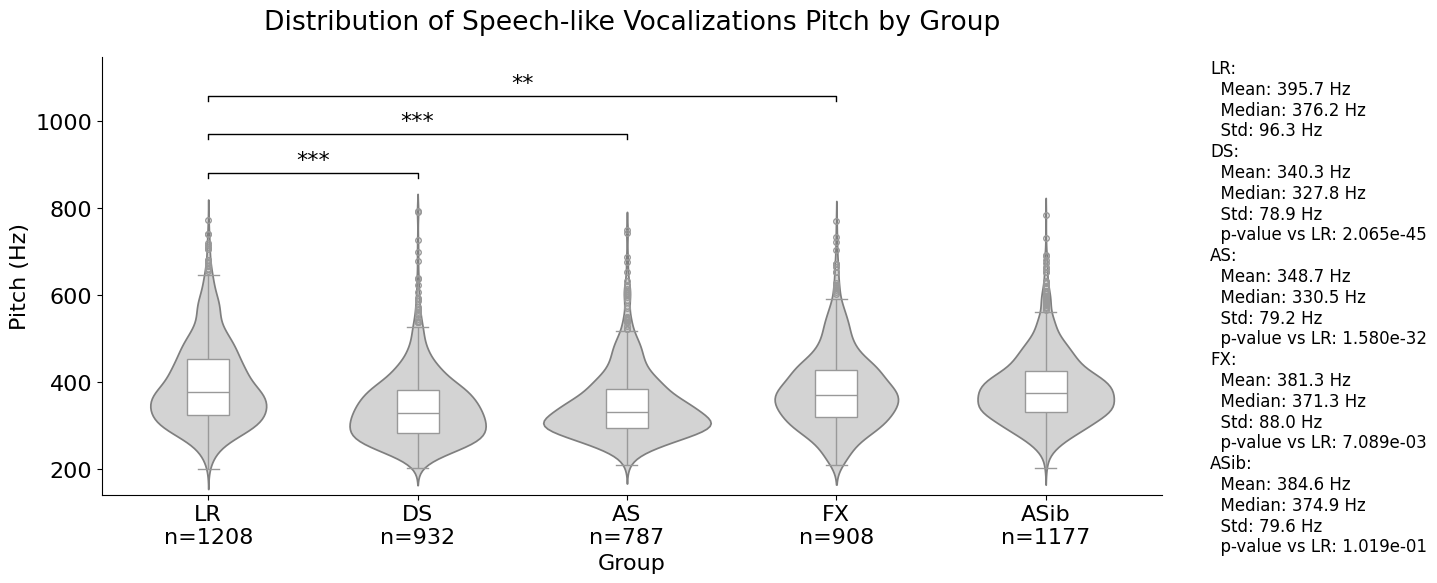

/tmp/ipykernel_22829/1543146153.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{label}\nn={group_sizes[label]}' for label in present_groups])


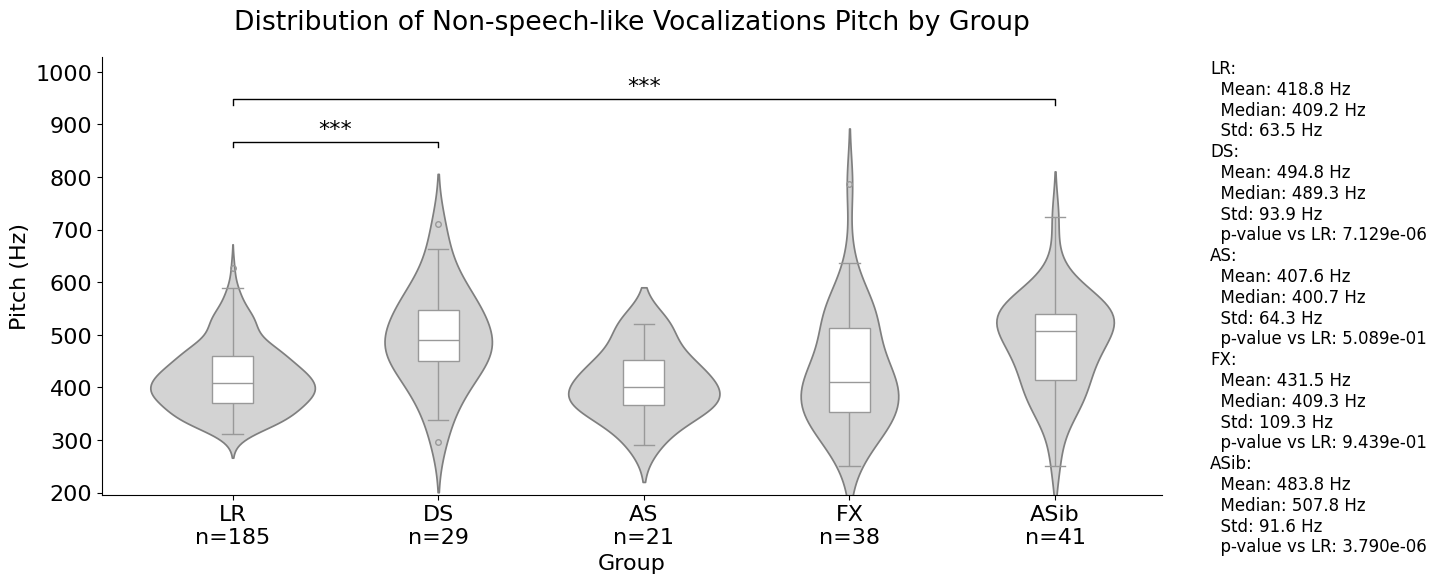

/tmp/ipykernel_22829/1543146153.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{label}\nn={group_sizes[label]}' for label in present_groups])


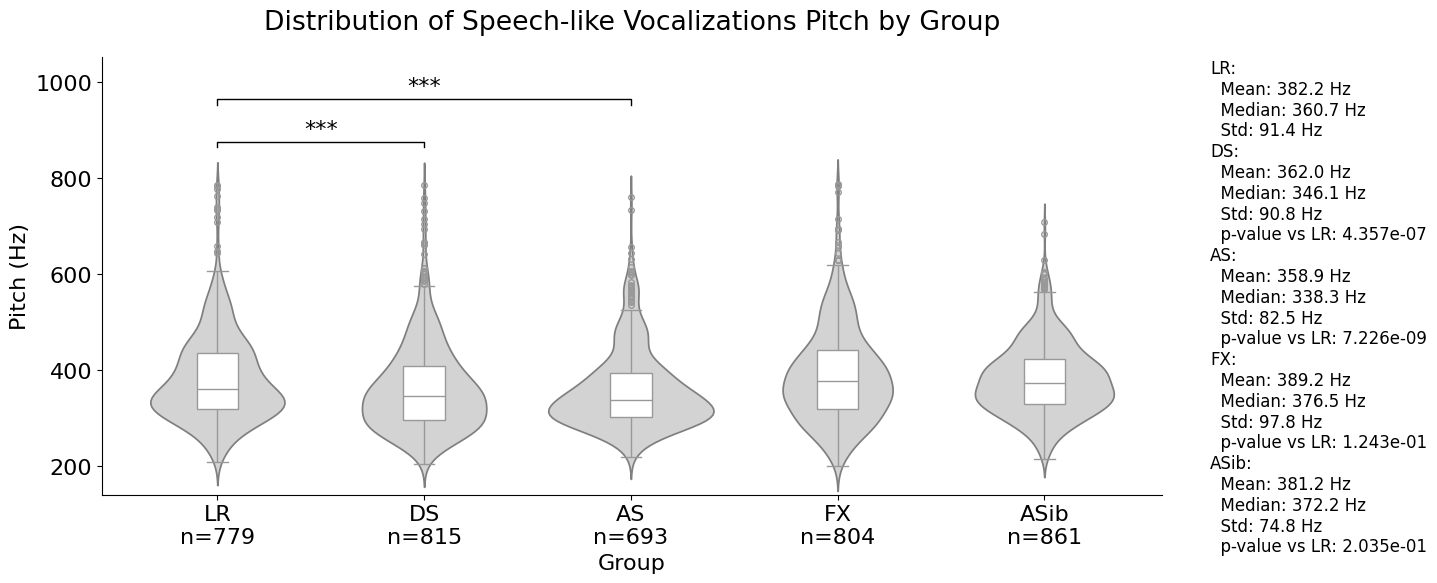

/tmp/ipykernel_22829/1543146153.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{label}\nn={group_sizes[label]}' for label in present_groups])


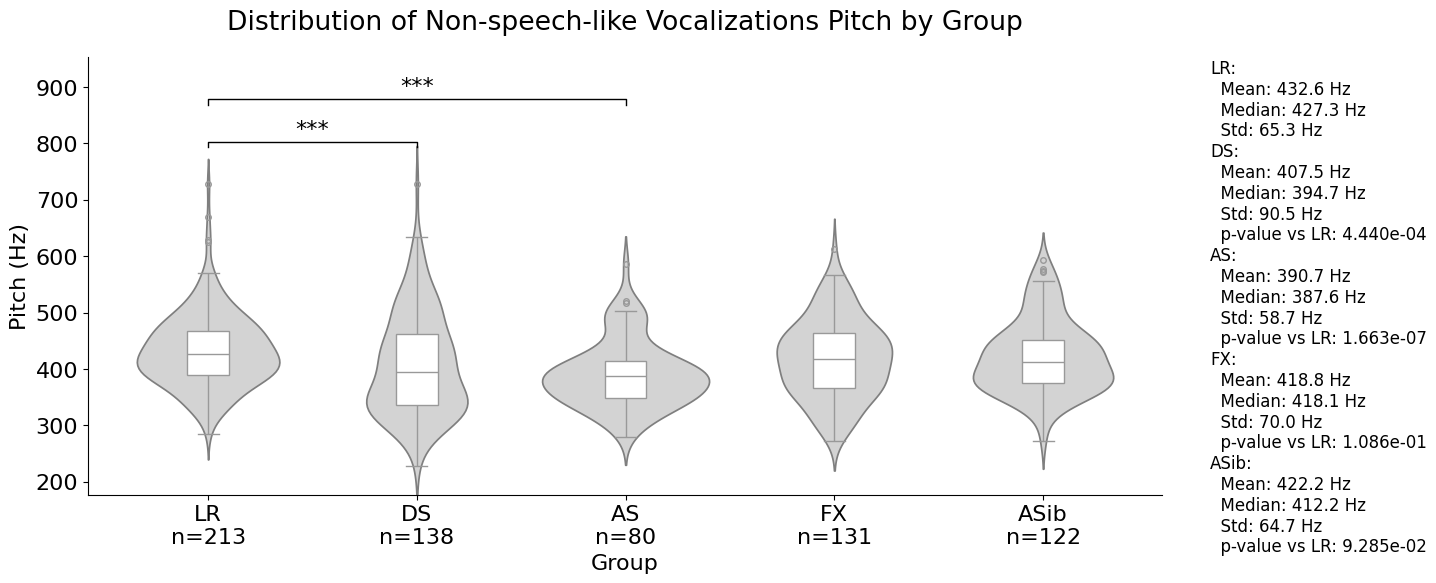

/tmp/ipykernel_22829/1543146153.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{label}\nn={group_sizes[label]}' for label in present_groups])


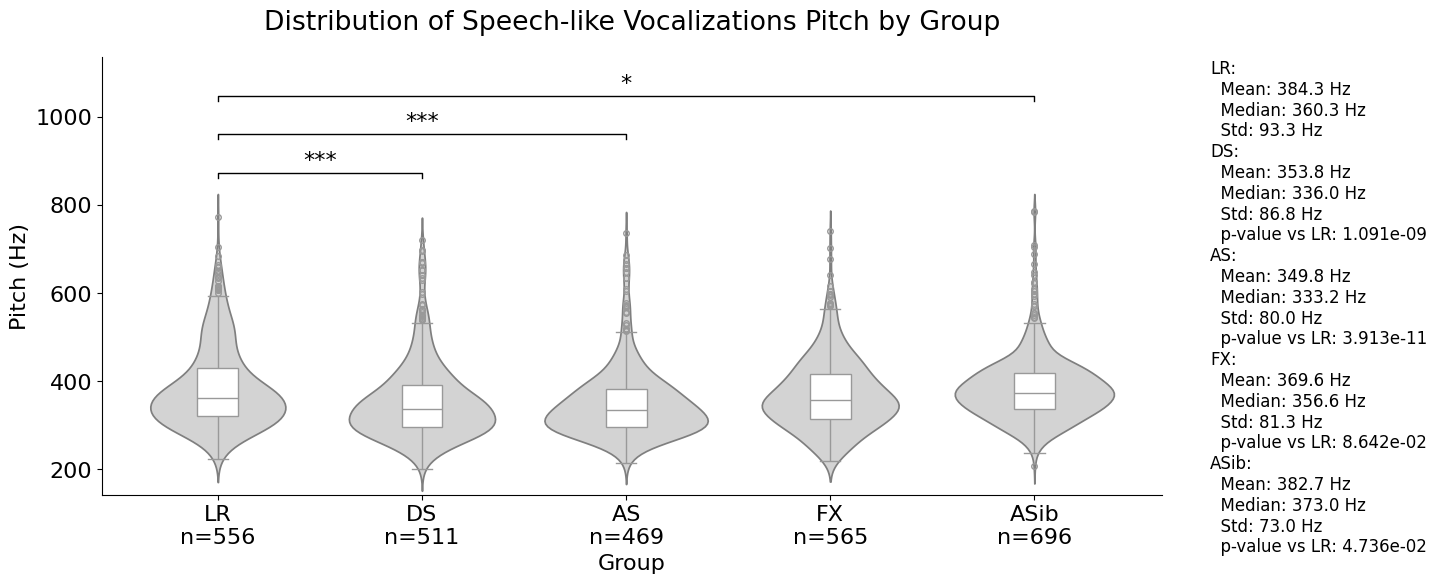

/tmp/ipykernel_22829/1543146153.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{label}\nn={group_sizes[label]}' for label in present_groups])


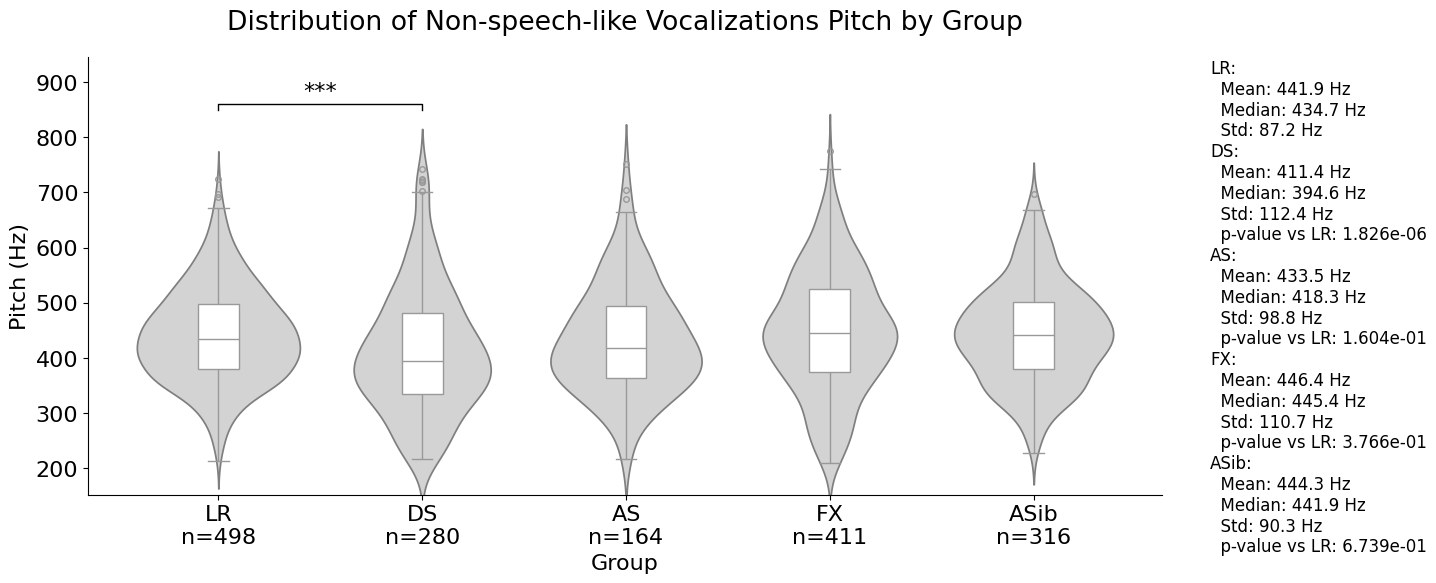

In [109]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

def plot_pitch_distribution(df, pitch_type='speechlike_pitch', figsize=(12, 6), 
                          violin=True, box=True, points=False):
    """
    Plot the distribution of pitch values across groups with significance testing against low_risk group.
    """    
    # Define group label mapping
    group_labels = {
        'low_risk': 'LR',
        'down_syndrome': 'DS',
        'angelman_syndrome': 'AS',
        'fragile_x_syndrome': 'FX',
        'autism_sibling': 'ASib'
    }
    
    # Create a long-format DataFrame for plotting
    plot_data = []
    for idx, row in df.iterrows():
        pitches = row[pitch_type]
        if pitches and hasattr(pitches, '__iter__'):
            plot_data.extend([
                {'group_id': group_labels.get(row['group_id'], str(row['group_id'])),
                 'pitch': float(pitch)}
                for pitch in pitches
                if pitch is not None
            ])
    
    plot_df = pd.DataFrame(plot_data)
    
    if plot_df.empty:
        raise ValueError(f"No valid pitch data found in column '{pitch_type}'")
    
    # Get the actual groups present in the data
    present_groups = sorted(plot_df['group_id'].unique(),
                          key=lambda x: ['LR', 'DS', 'AS', 'FX', 'ASib'].index(x) 
                          if x in ['LR', 'DS', 'AS', 'FX', 'ASib'] else float('inf'))
    
    # Create categorical type only for groups that are present
    plot_df['group_id'] = pd.Categorical(plot_df['group_id'], 
                                       categories=present_groups, 
                                       ordered=True)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Remove top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if violin:
        sns.violinplot(data=plot_df, x='group_id', y='pitch', 
                      color='lightgray', inner=None, ax=ax)
    
    if box:
        sns.boxplot(data=plot_df, x='group_id', y='pitch',
                   width=0.2, color='white', ax=ax)
    
    if points:
        sns.stripplot(data=plot_df, x='group_id', y='pitch',
                     size=2, color='black', alpha=0.1, ax=ax)
    
    # Add sample sizes below group labels
    group_sizes = plot_df['group_id'].value_counts().sort_index()
    ax.set_xticklabels([f'{label}\nn={group_sizes[label]}' for label in present_groups])
    
    # Perform statistical tests against LR group
    lr_data = plot_df[plot_df['group_id'] == 'LR']['pitch']
    y_max = plot_df['pitch'].max()
    y_range = plot_df['pitch'].max() - plot_df['pitch'].min()
    
    stats_results = {}
    for group in present_groups:
        if group != 'LR':
            group_data = plot_df[plot_df['group_id'] == group]['pitch']
            stat, p_value = stats.mannwhitneyu(lr_data, group_data, alternative='two-sided')
            stats_results[group] = p_value
            
            # Add significance stars
            stars = ''
            if p_value < 0.001:
                stars = '***'
            elif p_value < 0.01:
                stars = '**'
            elif p_value < 0.05:
                stars = '*'
                
            if stars:
                # Get x-coordinates of the groups
                lr_x = present_groups.index('LR')
                group_x = present_groups.index(group)
                
            # Only draw bars and stars if result is significant (p < 0.05)
            if p_value < 0.05:
                # Get index among significant results for spacing
                sig_groups = [g for g in present_groups if g != 'LR' and 
                            stats.mannwhitneyu(lr_data, 
                                             plot_df[plot_df['group_id'] == g]['pitch'], 
                                             alternative='two-sided')[1] < 0.05]
                current_sig_idx = sig_groups.index(group)
                
                # Calculate height based on position among significant results
                bar_height = y_max + y_range * (0.15 + current_sig_idx * 0.15)
                
                # Draw the connecting lines
                plt.plot([lr_x, lr_x, group_x, group_x], 
                        [bar_height-y_range*0.02, bar_height, bar_height, bar_height-y_range*0.02],
                        color='black', linewidth=1)
                
                # Add stars - slightly above the bar
                plt.text((lr_x + group_x)/2, bar_height + y_range*0.01, 
                        stars, ha='center', va='bottom')
    
    # Customize the plot
    title = 'Distribution of Speech-like Vocalizations Pitch by Group' if pitch_type == 'speechlike_pitch' else 'Distribution of Non-speech-like Vocalizations Pitch by Group'
    plt.title(title)
    plt.xlabel('Group')
    plt.ylabel('Pitch (Hz)')
    
    # Add summary statistics and p-values as text
    stats_text = ''
    for group in present_groups:
        group_data = plot_df[plot_df['group_id'] == group]['pitch']
        stats_text += f'\n{group}:\n'
        stats_text += f'  Mean: {group_data.mean():.1f} Hz\n'
        stats_text += f'  Median: {group_data.median():.1f} Hz\n'
        stats_text += f'  Std: {group_data.std():.1f} Hz'
        if group != 'LR' and group in stats_results:
            stats_text += f'\n  p-value vs LR: {stats_results[group]:.3e}'
    
    plt.figtext(1.02, 0.5, stats_text, 
                fontsize=12, va='center')
    
    # Get number of significant comparisons for plot height
    num_sig_comparisons = len([g for g in present_groups if g != 'LR' and 
                             stats.mannwhitneyu(plot_df[plot_df['group_id'] == 'LR']['pitch'],
                                              plot_df[plot_df['group_id'] == g]['pitch'],
                                              alternative='two-sided')[1] < 0.05])
    
    # Adjust plot height based on number of significant bars
    plt.ylim(plot_df['pitch'].min() - y_range*0.1, 
             y_max + y_range*(0.15 + num_sig_comparisons * 0.15))
    
    # Adjust layout to prevent title overlap
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Make more room for title
    
    # Move title up
    ax.set_title(title, pad=20)
    return fig

fig = plot_pitch_distribution(human_measures, pitch_type='speechlike_pitch', violin=True, box=True, points=False)
plt.savefig('/home/engaclew/neurogen/figures/pitch/human_speechlike_pitch.png', dpi=300, bbox_inches='tight')
plt.show()


fig = plot_pitch_distribution(human_measures, pitch_type='nonspeechlike_pitch', violin=True, box=True, points=False)
plt.savefig('/home/engaclew/neurogen/figures/pitch/human_nonspeechlike_pitch.png', dpi=300, bbox_inches='tight')
plt.show()


fig = plot_pitch_distribution(aclew_measures, pitch_type='speechlike_pitch', violin=True, box=True, points=False)
plt.savefig('/home/engaclew/neurogen/figures/pitch/aclew_speechlike_pitch.png', dpi=300, bbox_inches='tight')
plt.show()

fig = plot_pitch_distribution(aclew_measures, pitch_type='nonspeechlike_pitch', violin=True, box=True, points=False)
plt.savefig('/home/engaclew/neurogen/figures/pitch/aclew_nonspeechlike_pitch.png', dpi=300, bbox_inches='tight')
plt.show()

fig = plot_pitch_distribution(lena_measures, pitch_type='speechlike_pitch', violin=True, box=True, points=False)
plt.savefig('/home/engaclew/neurogen/figures/pitch/lena_speechlike_pitch.png', dpi=300, bbox_inches='tight')
plt.show()

fig = plot_pitch_distribution(lena_measures, pitch_type='nonspeechlike_pitch', violin=True, box=True, points=False)
plt.savefig('/home/engaclew/neurogen/figures/pitch/lena_nonspeechlike_pitch.png', dpi=300, bbox_inches='tight')
plt.show()